We first load the data and augment it as always.

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
%matplotlib inline

# Create the dataset
data = {
    'Quizzes': [5.3, 5.5, 5.5, 5.0, 2.5, 3.0, 3.0, 3.1, 3.5, 3.5, 3.7, 4.0, 4.0, 4.0, 4.0, 5.7],
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Create pass/fail labels (1 for Pass, 0 for Fail)
df['Pass'] = df['Final'].apply(lambda x: 1 if x >= 4.0 else 0)

# augment data 
np.random.seed(42)
augmented_data = []

# the original data points
for i, row in df.iterrows():
    augmented_data.append({
        'Quizzes': row['Quizzes'],
        'Labs': row['Labs'],
        'Final': row['Final'],
        'Pass': row['Pass']
    })

# now we add 10 variations with noise for each original point
for i, row in df.iterrows():
    for j in range(10):
        # Create noise for each feature
        noise_quiz = np.random.normal(0, 0.2)
        noise_lab = np.random.normal(0, 0.2)
        noise_final = np.random.normal(0, 0.2)
        
        
        new_quiz = min(max(row['Quizzes'] + noise_quiz, 2), 6)
        new_lab = min(max(row['Labs'] + noise_lab, 2), 6)
        new_final = min(max(row['Final'] + noise_final, 2), 6)
        
        # Determine pass/fail based on noisy final score
        new_pass = 1 if new_final >= 4.0 else 0
        
        # Add to augmented data
        augmented_data.append({
            'Quizzes': new_quiz,
            'Labs': new_lab,
            'Final': new_final,
            'Pass': new_pass
        })

# Convert augmented data to DataFrame
df_aug = pd.DataFrame(augmented_data)

Now we will prepare the data for clustering by selecting the relevant features (in this case we do not include the target variable (final grade), and we standardize the data. Then we implement K-means clustering with the sklearn method. We also calculate the cluster purity (how many "Fail" points are in the cluster that is domeinated by data points corresponding to a "Pass" label.

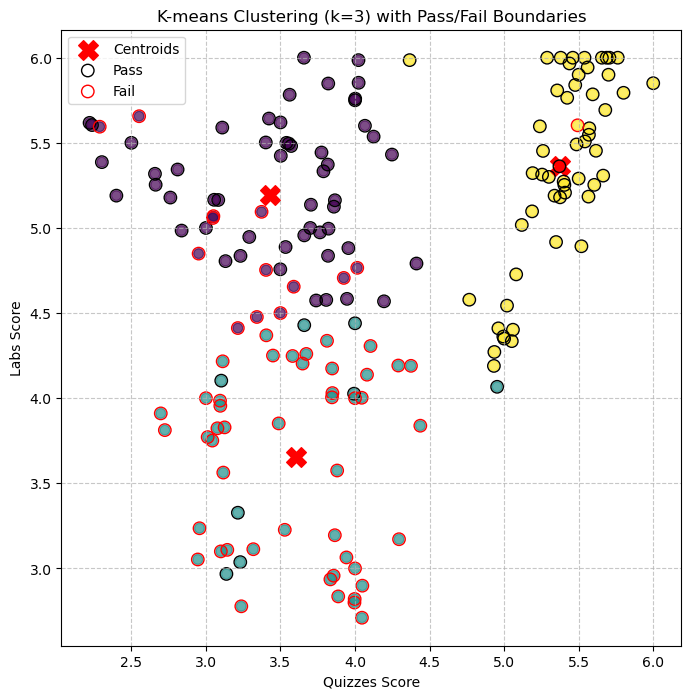


Cluster vs Pass/Fail Cross-tabulation:
Pass/Fail  0.0  1.0
Cluster            
0           13   53
1           47    8
2            1   54

Cluster Means:
          Quizzes      Labs     Final      Pass
Cluster                                        
0        3.427493  5.191602  4.692290  0.803030
1        3.603580  3.654362  3.525769  0.145455
2        5.372711  5.363573  5.172097  0.981818

Cluster Purity (how well each cluster contains a single class):
Cluster 0: 80.30%
Cluster 1: 85.45%
Cluster 2: 98.18%

Overall Clustering Purity: 87.50%


In [71]:
# features for clustering
X = df_aug[['Quizzes', 'Labs']]

# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# we will now implement K-means clustering with different numbers of clusters

# Let's say k=3 was determined to be optimal (see in the next cell how it is determined))
optimal_k = 3  # This will be determined from the elbow plot

#  K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_aug['Cluster'] = kmeans.fit_predict(X_scaled)

# clusters
plt.figure(figsize=(8, 8))


scatter = plt.scatter(df_aug['Quizzes'], df_aug['Labs'], 
                     c=df_aug['Cluster'], cmap='viridis', 
                     s=50, alpha=0.7)

# centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Centroids')

#  Pass adn Fail indications
plt.scatter(df_aug[df_aug['Pass']==1]['Quizzes'], df_aug[df_aug['Pass']==1]['Labs'], 
           edgecolor='black', facecolor='none', s=80, label='Pass')
plt.scatter(df_aug[df_aug['Pass']==0]['Quizzes'], df_aug[df_aug['Pass']==0]['Labs'], 
           edgecolor='red', facecolor='none', s=80, label='Fail')

plt.legend()
plt.title(f'K-means Clustering (k={optimal_k}) with Pass/Fail Boundaries')
plt.xlabel('Quizzes Score')
plt.ylabel('Labs Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
plt.savefig('kmeans_clusters.png')
plt.close()


cross_tab = pd.crosstab(df_aug['Cluster'], df_aug['Pass'], 
                        rownames=['Cluster'], colnames=['Pass/Fail'])
print("\nCluster vs Pass/Fail Cross-tabulation:")
print(cross_tab)

cluster_means = df_aug.groupby('Cluster').mean()
print("\nCluster Means:")
print(cluster_means)

#  clusters purity
cluster_purity = {}
for cluster in range(optimal_k):
    cluster_data = df_aug[df_aug['Cluster'] == cluster]
    max_class_count = max(sum(cluster_data['Pass'] == 1), sum(cluster_data['Pass'] == 0))
    purity = max_class_count / len(cluster_data)
    cluster_purity[cluster] = purity

print("\nCluster Purity (how well each cluster contains a single class):")
for cluster, purity in cluster_purity.items():
    print(f"Cluster {cluster}: {purity:.2%}")

total_correct = 0
for cluster in range(optimal_k):
    cluster_data = df_aug[df_aug['Cluster'] == cluster]
    max_class_count = max(sum(cluster_data['Pass'] == 1), sum(cluster_data['Pass'] == 0))
    total_correct += max_class_count

overall_purity = total_correct / len(df_aug)
print(f"\nOverall Clustering Purity: {overall_purity:.2%}")

We will now make a small study to determine the best number of clusters, using two metrics: silhouette score, and the elbow method.


Percentage decrease in inertia between consecutive k values:
k=2: decrease=50.21%
k=3: decrease=47.48%
k=4: decrease=29.02%
k=5: decrease=20.49%


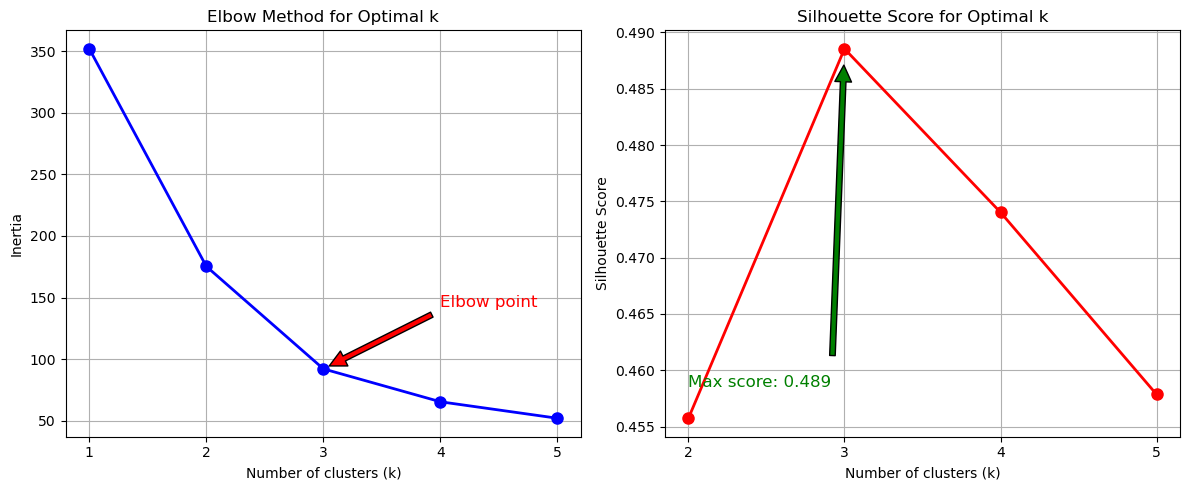


Optimal Number of Clusters Analysis:
--------------------------------------------------
Based on the elbow method: k=3
Based on maximum silhouette score: k=3

Cluster vs Pass/Fail Cross-tabulation:
Pass/Fail  0.0  1.0
Cluster            
0           13   53
1           47    8
2            1   54

Cluster Statistics:
         Quizzes_mean  Quizzes_min  Quizzes_max  Labs_mean  Labs_min  Labs_max  Pass_rate  Count
Cluster                                                                                         
0            3.427493     2.219630     4.412150   5.191602  4.411991      6.00  80.303030     66
1            3.603580     2.697031     4.953083   3.654362  2.710383      4.44  14.545455     55
2            5.372711     4.366292     6.000000   5.363573  4.189545      6.00  98.181818     55

Overall Clustering Purity: 87.50%


In [72]:


# K-means clustering with different numbers of clusters
# we will first calculate inertia (sum of squared distances) for elbow method
inertia = []
silhouette_scores = []
k_range = range(1, 6)  # Test from 1 to 10 clusters

for k in k_range:
    if k == 1:
        # For k=1, just calculate inertia
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(0)  # Silhouette score not defined for k=1
    else:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)
        inertia.append(kmeans.inertia_)
        
        # silhouette score 
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)


# Calculate the percentage decrease in inertia
inertia_decrease = [(inertia[i-1] - inertia[i])/inertia[i-1]*100 for i in range(1, len(inertia))]
print("\nPercentage decrease in inertia between consecutive k values:")
for k, decrease in zip(k_range[1:], inertia_decrease):
    print(f"k={k}: decrease={decrease:.2f}%")

# Find k with max silhouette score
max_silhouette_idx = np.argmax(silhouette_scores[1:])
max_silhouette_k = max_silhouette_idx + 2  # +2 because we skipped k=1 and indices start at 0

# elbow method plot
plt.figure(figsize=(12, 5))

# Inertia plot (Elbow method)
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.xticks(k_range)

elbow_point = 3  # Based on visual inspection and analysis
plt.annotate('Elbow point', xy=(elbow_point, inertia[elbow_point-1]), 
             xytext=(elbow_point+1, inertia[elbow_point-1]+50),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=12, color='red')

# Silhouette score plot 
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], silhouette_scores[1:], 'ro-', linewidth=2, markersize=8)  # Skip k=1
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)
plt.xticks(k_range[1:])

plt.annotate(f'Max score: {silhouette_scores[1:][max_silhouette_idx]:.3f}', 
             xy=(max_silhouette_k, silhouette_scores[1:][max_silhouette_idx]),
             xytext=(max_silhouette_k-1, silhouette_scores[1:][max_silhouette_idx]-0.03),
             arrowprops=dict(facecolor='green', shrink=0.05),
             fontsize=12, color='green')

plt.tight_layout()
plt.show()
plt.savefig('elbow_method_analysis.png')
plt.close()

# Final analysis
print("\nOptimal Number of Clusters Analysis:")
print("-" * 50)
print(f"Based on the elbow method: k={elbow_point}")
print(f"Based on maximum silhouette score: k={max_silhouette_k}")

# Calculate cluster results with optimal k from elbow method
optimal_k = elbow_point
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_aug['Cluster'] = kmeans.fit_predict(X_scaled)

cross_tab = pd.crosstab(df_aug['Cluster'], df_aug['Pass'], 
                       rownames=['Cluster'], colnames=['Pass/Fail'])
print("\nCluster vs Pass/Fail Cross-tabulation:")
print(cross_tab)

# Calculate cluster statistics
cluster_stats = df_aug.groupby('Cluster').agg({
    'Quizzes': ['mean', 'min', 'max'],
    'Labs': ['mean', 'min', 'max'],
    'Pass': ['mean', 'count']
})
cluster_stats.columns = ['Quizzes_mean', 'Quizzes_min', 'Quizzes_max', 
                        'Labs_mean', 'Labs_min', 'Labs_max', 
                        'Pass_rate', 'Count']
cluster_stats['Pass_rate'] = cluster_stats['Pass_rate'] * 100  # Convert to percentage

print("\nCluster Statistics:")
print(cluster_stats)

# Calculate how well the clusters separate the Pass/Fail classes
total_correct = 0
for cluster in range(optimal_k):
    cluster_data = df_aug[df_aug['Cluster'] == cluster]
    max_class_count = max(sum(cluster_data['Pass'] == 1), sum(cluster_data['Pass'] == 0))
    total_correct += max_class_count

overall_purity = total_correct / len(df_aug)
print(f"\nOverall Clustering Purity: {overall_purity:.2%}")



Now we will see what DBSCAN will do with this dataset. The question is, will DBSCAN find the same clustering?
We will look at different combinations of the parameters epsilon and minPts, and hopefully the one which gives a good silhouette score metric will correspond to the clustering of the K-means method. But this is not guaranteed.

In [79]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import seaborn as sns


# the grid of parameters to test
epsilon_values = [0.2, 0.3, 0.5, 0.6, 0.7,1]
min_pts_values = [ 5,8,9,10,15,25]

# Initialize results storage
results = []

# Test each combination of parameters
for eps in epsilon_values:
    for min_pts in min_pts_values:
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_pts)
        labels = dbscan.fit_predict(X_scaled)
        
        # Calculate number of clusters (excluding noise)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_percentage = n_noise / len(X_scaled) * 100
        
        # Calculate silhouette score if valid
        if n_clusters > 1 and n_noise < len(X_scaled):
            # Filter out noise points for silhouette calculation
            mask = labels != -1
            if sum(mask) > 1:  # Need at least 2 points for silhouette
                sil_score = silhouette_score(X_scaled[mask], labels[mask])
            else:
                sil_score = -1
        else:
            sil_score = -1
        
        # Store results
        results.append({
            'eps': eps,
            'min_pts': min_pts,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_percentage': noise_percentage,
            'silhouette': sil_score
        })
        

# Convert results to DataFrame
results_df = pd.DataFrame(results)

Now let's look at the parameters plot and where we observe the largest silhouette score.
For this particular data it happens at epsilon=0.5 and minPts=25 (this might change from run to run if the train vs test splitting is not fixed). This clustering does not look very easy to explain.

<Figure size 500x500 with 0 Axes>


DBSCAN Cluster Distribution:
Noise points: 100 (56.82%)
Cluster 0: 44 (25.00%)
Cluster 1: 32 (18.18%)

Cluster vs Pass/Fail Cross-tabulation:
Pass/Fail  0.0  1.0
Cluster            
-1          45   55
 0           1   43
 1          15   17

Cluster Statistics:
         Quizzes_mean  Quizzes_min  Quizzes_max  Labs_mean  Labs_min  Labs_max  Pass_rate  Count
Cluster                                                                                         
-1           3.613175     2.219630     5.080810   4.463231  2.710383       6.0  55.000000    100
 0           5.484851     5.118395     6.000000   5.564553  4.892486       6.0  97.727273     44
 1           3.664363     3.131311     4.194314   4.608398  4.174464       5.0  53.125000     32


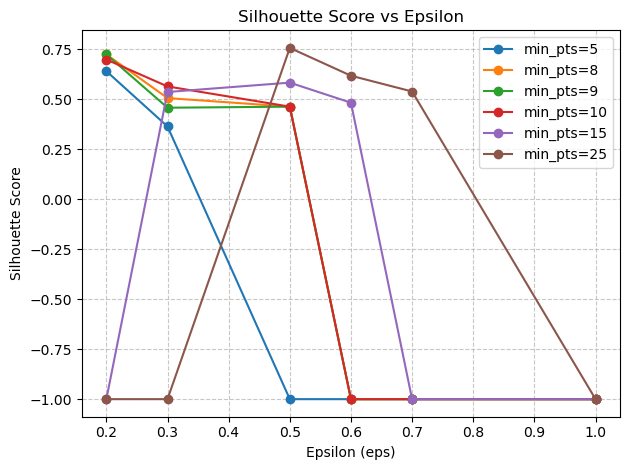

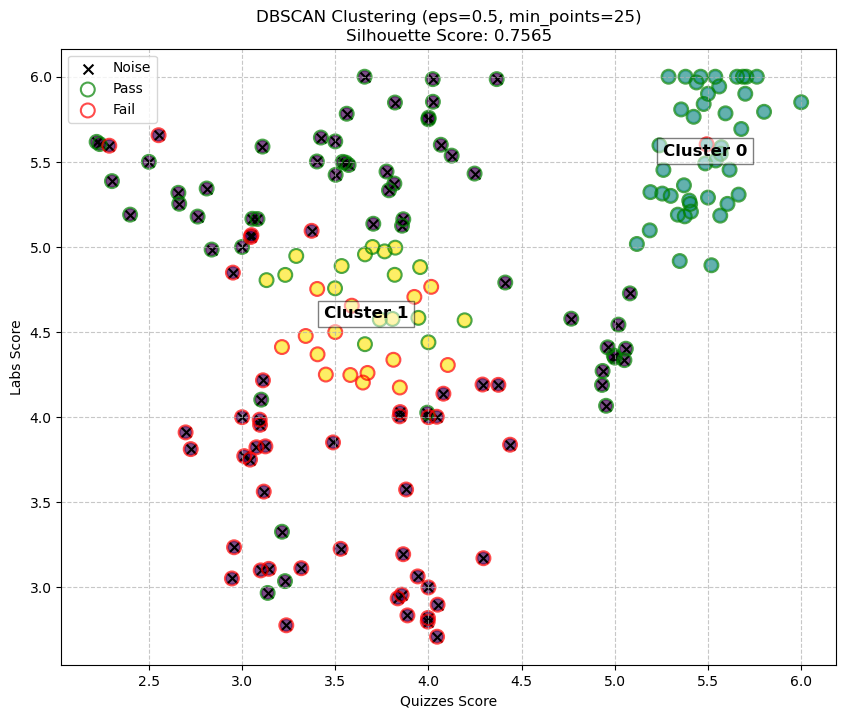

In [80]:
valid_results = results_df[results_df['silhouette'] > -1]  # Filter out invalid results
best_result = valid_results.loc[valid_results['silhouette'].idxmax()]

#  Line plot of silhouette scores vs epsilon for each min_pts
plt.figure(figsize=(5,5))
plt.show()
for min_pts in sorted(results_df['min_pts'].unique()):
    subset = results_df[results_df['min_pts'] == min_pts]
    plt.plot(subset['eps'], subset['silhouette'], 'o-', label=f'min_pts={min_pts}')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Epsilon')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.savefig('dbscan_parameter_analysis.png')

# Apply DBSCAN with the best parameters
if len(valid_results) > 0:
    best_eps = best_result['eps']
    best_min_pts = int(best_result['min_pts'])
    
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_pts)
    df_aug['Cluster'] = dbscan.fit_predict(X_scaled)
    
    # Analyze the clustering results
    print("\nDBSCAN Cluster Distribution:")
    for cluster in sorted(df_aug['Cluster'].unique()):
        if cluster == -1:
            print(f"Noise points: {sum(df_aug['Cluster'] == -1)} ({sum(df_aug['Cluster'] == -1)/len(df_aug):.2%})")
        else:
            print(f"Cluster {cluster}: {sum(df_aug['Cluster'] == cluster)} ({sum(df_aug['Cluster'] == cluster)/len(df_aug):.2%})")
    
    # Compare with Pass/Fail
    cross_tab = pd.crosstab(df_aug['Cluster'], df_aug['Pass'], 
                           rownames=['Cluster'], colnames=['Pass/Fail'])
    print("\nCluster vs Pass/Fail Cross-tabulation:")
    print(cross_tab)
    
    # Calculate cluster purity
    cluster_stats = df_aug.groupby('Cluster').agg({
        'Quizzes': ['mean', 'min', 'max'],
        'Labs': ['mean', 'min', 'max'],
        'Pass': ['mean', 'count']
    })
    
    # Clean up the column names
    cluster_stats.columns = ['Quizzes_mean', 'Quizzes_min', 'Quizzes_max', 
                           'Labs_mean', 'Labs_min', 'Labs_max', 
                           'Pass_rate', 'Count']
    cluster_stats['Pass_rate'] = cluster_stats['Pass_rate'] * 100  # Convert to percentage
    
    print("\nCluster Statistics:")
    print(cluster_stats)
    
    # Visualize the clusters
    plt.figure(figsize=(10, 8))
    
    # Create a scatter plot with points colored by cluster
    scatter = plt.scatter(df_aug['Quizzes'], df_aug['Labs'], 
                         c=df_aug['Cluster'], cmap='viridis', 
                         s=70, alpha=0.7)
    
    # Add cluster labels
    for cluster in sorted(df_aug['Cluster'].unique()):
        if cluster != -1:  # Skip noise
            cluster_points = df_aug[df_aug['Cluster'] == cluster]
            center_x = cluster_points['Quizzes'].mean()
            center_y = cluster_points['Labs'].mean()
            plt.text(center_x, center_y, f'Cluster {cluster}', 
                    fontsize=12, fontweight='bold', 
                    ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.5))
    
    # Add a special marker for noise points
    if -1 in df_aug['Cluster'].unique():
        plt.scatter(df_aug[df_aug['Cluster'] == -1]['Quizzes'], 
                   df_aug[df_aug['Cluster'] == -1]['Labs'],
                   c='black', marker='x', s=50, label='Noise')
    
    # Overlay Pass/Fail 
    plt.scatter(df_aug[df_aug['Pass'] == 1]['Quizzes'], 
               df_aug[df_aug['Pass'] == 1]['Labs'], 
               facecolors='none', edgecolors='green', 
               s=100, linewidth=1.5, alpha=0.7, label='Pass')
    
    plt.scatter(df_aug[df_aug['Pass'] == 0]['Quizzes'], 
               df_aug[df_aug['Pass'] == 0]['Labs'], 
               facecolors='none', edgecolors='red', 
               s=100, linewidth=1.5, alpha=0.7, label='Fail')
    
    plt.title(f'DBSCAN Clustering (eps={best_eps}, min_points={best_min_pts})\nSilhouette Score: {best_result["silhouette"]:.4f}')
    plt.xlabel('Quizzes Score')
    plt.ylabel('Labs Score')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    

Now we will visualize the silhouette score for all data points, for a K-means clustering with k=3.


K-means with k=3
Average silhouette score: 0.4885
Cluster 0 average silhouette score: 0.4525
Cluster 1 average silhouette score: 0.4186
Cluster 2 average silhouette score: 0.6017

Cluster Statistics:
         Quizzes_mean  Quizzes_min  Quizzes_max  Labs_mean  Labs_min  Labs_max  Pass_rate  Count
Cluster                                                                                         
0            3.427493     2.219630     4.412150   5.191602  4.411991      6.00  80.303030     66
1            3.603580     2.697031     4.953083   3.654362  2.710383      4.44  14.545455     55
2            5.372711     4.366292     6.000000   5.363573  4.189545      6.00  98.181818     55

Cluster vs Pass/Fail Cross-tabulation:
Pass/Fail  0.0  1.0
Cluster            
0           13   53
1           47    8
2            1   54

Overall Clustering Purity: 87.50%

Cluster Purity (how well each cluster contains a single class):
Cluster 0: 80.30%
Cluster 1: 85.45%
Cluster 2: 98.18%


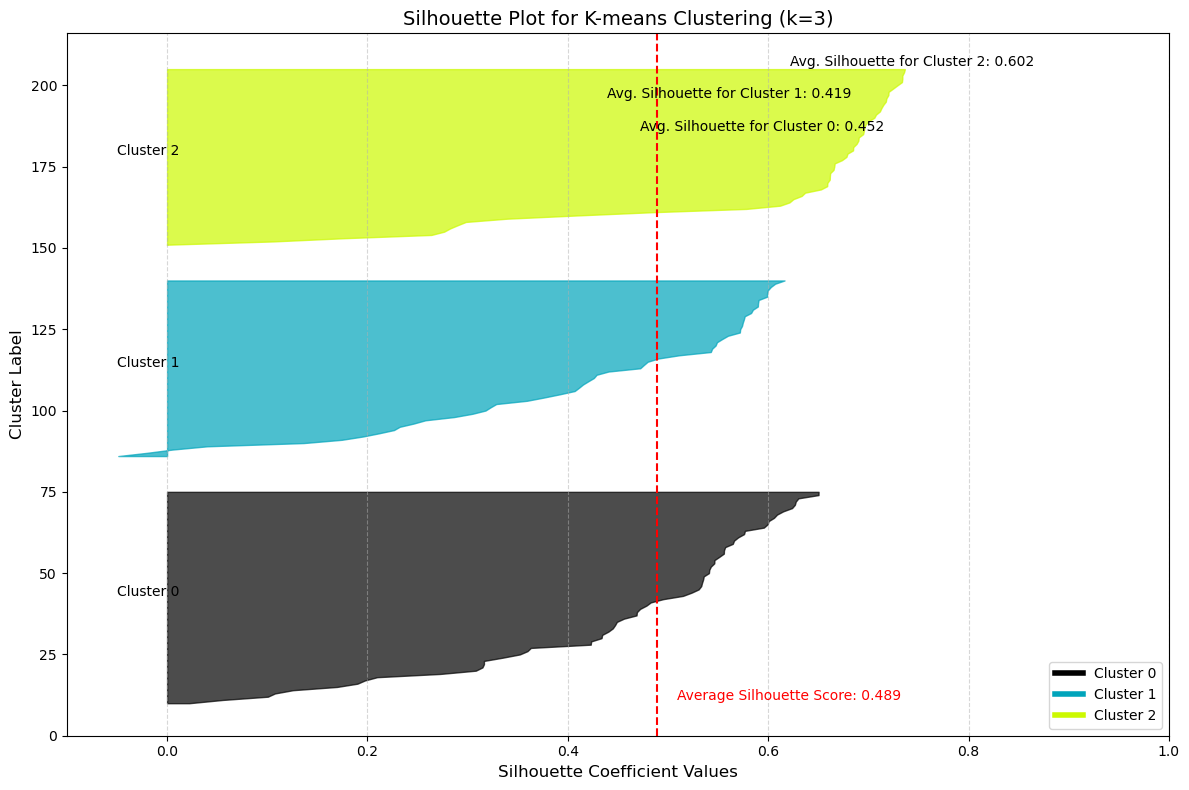

In [82]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm



# Apply K-means with k=3
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Get silhouette scores
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

print(f"\nK-means with k={n_clusters}")
print(f"Average silhouette score: {silhouette_avg:.4f}")

# Get cluster statistics
df_aug['Cluster'] = cluster_labels
cluster_stats = df_aug.groupby('Cluster').agg({
    'Quizzes': ['mean', 'min', 'max'],
    'Labs': ['mean', 'min', 'max'],
    'Pass': ['mean', 'count'],
})

# Calculate average silhouette score per cluster
for i in range(n_clusters):
    cluster_silhouette = sample_silhouette_values[cluster_labels == i].mean()
    print(f"Cluster {i} average silhouette score: {cluster_silhouette:.4f}")

# Clean up column names
cluster_stats.columns = ['Quizzes_mean', 'Quizzes_min', 'Quizzes_max', 
                        'Labs_mean', 'Labs_min', 'Labs_max', 
                        'Pass_rate', 'Count']
cluster_stats['Pass_rate'] = cluster_stats['Pass_rate'] * 100  # Convert to percentage

print("\nCluster Statistics:")
print(cluster_stats)

# Compare with Pass/Fail
cross_tab = pd.crosstab(df_aug['Cluster'], df_aug['Pass'], 
                        rownames=['Cluster'], colnames=['Pass/Fail'])
print("\nCluster vs Pass/Fail Cross-tabulation:")
print(cross_tab)

# Calculate cluster purity
total_correct = 0
for cluster in range(n_clusters):
    cluster_data = df_aug[df_aug['Cluster'] == cluster]
    max_class_count = max(sum(cluster_data['Pass'] == 1), sum(cluster_data['Pass'] == 0))
    total_correct += max_class_count

overall_purity = total_correct / len(df_aug)
print(f"\nOverall Clustering Purity: {overall_purity:.2%}")

print("\nCluster Purity (how well each cluster contains a single class):")
for cluster in range(n_clusters):
    cluster_data = df_aug[df_aug['Cluster'] == cluster]
    max_class_count = max(sum(cluster_data['Pass'] == 1), sum(cluster_data['Pass'] == 0))
    purity = max_class_count / len(cluster_data)
    print(f"Cluster {cluster}: {purity:.2%}")

# Create a silhouette plot
# Code adapted from scikit-learn examples:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

plt.figure(figsize=(12, 8))

# The silhouette coefficient can range from -1 to 1
# Values near +1 indicate the sample is far away from neighboring clusters
# Values near 0 indicate the sample is on or very close to the decision boundary between two clusters
# Values near -1 indicate the sample may have been assigned to the wrong cluster

# For each cluster
y_lower = 10
for i in range(n_clusters):
    # Get silhouette scores for points in this cluster
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    
    # Sort silhouette values in descending order
    ith_cluster_silhouette_values.sort()
    
    # Get size of this cluster
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    # Generate colors for clusters
    color = cm.nipy_spectral(float(i) / n_clusters)
    
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # silhouette plots with their cluster numbers
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
# Calculate and add per-cluster silhouette scores to the plot
for i in range(n_clusters):
    cluster_silhouette = sample_silhouette_values[cluster_labels == i].mean()
    plt.text(cluster_silhouette + 0.02, y_lower - 10 * (n_clusters - i), 
             f'Avg. Silhouette for Cluster {i}: {cluster_silhouette:.3f}', 
             fontsize=10)

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.text(silhouette_avg + 0.02, plt.ylim()[0] + 0.05 * (plt.ylim()[1] - plt.ylim()[0]), 
         f'Average Silhouette Score: {silhouette_avg:.3f}', color="red")

plt.title(f'Silhouette Plot for K-means Clustering (k={n_clusters})', fontsize=14)
plt.xlabel('Silhouette Coefficient Values', fontsize=12)
plt.ylabel('Cluster Label', fontsize=12)

plt.xlim([-0.1, 1])
plt.ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

legend_elements = []
for i in range(n_clusters):
    color = cm.nipy_spectral(float(i) / n_clusters)
    legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=f'Cluster {i}'))
plt.legend(handles=legend_elements, loc='lower right')

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('kmeans_silhouette_plot.png')

